In [1]:
#import statements
import zipfile
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from google.colab import drive
import shutil
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB3,EfficientNetV2S
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, LeakyReLU, BatchNormalization, Reshape
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


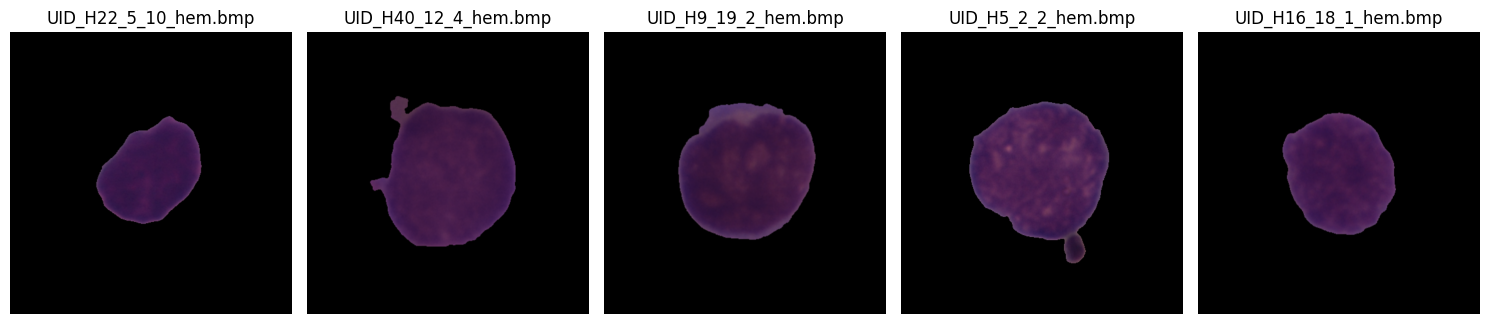

In [3]:
#displaying 5 random images from the dataset

dataset_path = "/content/drive/MyDrive/C-NMC_Leukemia/training_data"

# leukemia and normal folders inside training data
leukemia_images = os.listdir(os.path.join(dataset_path, "leukemiaSmears"))
normal_images = os.listdir(os.path.join(dataset_path, "normalSmears"))

#5 random images (3 from leukemia and 2 from normal)
selected_images =random.sample(normal_images, 5)

# display
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for ax, image_name in zip(axes, selected_images):
    image_path = os.path.join(dataset_path, "leukemiaSmears" if image_name in leukemia_images else "normalSmears", image_name)
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title(image_name)
    ax.axis('off')

plt.tight_layout()
plt.show()



In [4]:
#number of elements in each class
normalFolder = "/content/drive/MyDrive/C-NMC_Leukemia/training_data/normalSmears"
leukemiaFolder = "/content/drive/MyDrive/C-NMC_Leukemia/training_data/leukemiaSmears"

normalFolderContent = os.listdir(normalFolder)
leukemiaFolderContent = os.listdir(leukemiaFolder)

num_items_hem = len(normalFolderContent)
num_items_all = len(leukemiaFolderContent)

print("There are", num_items_hem, "normal blood smears.")
print("There are", num_items_all, "leukemia blood smears.")

There are 3389 normal blood smears.
There are 3389 leukemia blood smears.


In [5]:
# Image Resize Settings
imageResize = (128, 128)

# Define preprocessing function
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Error loading image: {image_path}")

    img = cv2.resize(img, imageResize)  # Resize
    img = img / 255.0  # Normalize pixel values
    img = (img * 255).astype(np.uint8)

    # Apply CLAHE (Contrast Enhancement)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)

    # Convert back to BGR for model compatibility
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Apply Median Blur for noise removal
    img = cv2.medianBlur(img, 3)

    return img


In [6]:

train_images = []
train_labels = []

for filename in os.listdir(leukemiaFolder):
    img_path = os.path.join(leukemiaFolder, filename)
    processed_img = preprocess_image(img_path)
    train_images.append(processed_img)
    train_labels.append(1)  # 1 = leukemia

for filename in os.listdir(normalFolder):
    img_path = os.path.join(normalFolder, filename)
    processed_img = preprocess_image(img_path)
    train_images.append(processed_img)
    train_labels.append(0)  # 0 = normal

# Convert to NumPy arrays
X_train = np.array(train_images)
y_train = np.array(train_labels)

# Shuffle dataset
shuffle_idx = np.random.permutation(len(X_train))
X_train, y_train = X_train[shuffle_idx], y_train[shuffle_idx]

print(f"Training Data Loaded: {X_train.shape}, Labels: {y_train.shape}")



Training Data Loaded: (6778, 128, 128, 3), Labels: (6778,)


In [7]:
# ---------- GAN: Generate Synthetic Images ----------
# Define Generator Model
def build_generator():
    model = Sequential([
        Dense(256, activation="relu", input_shape=(100,)),
        Dense(512, activation="relu"),
        Dense(1024, activation="relu"),
        Dense(128 * 128 * 3, activation="tanh"),
        Reshape((128, 128, 3))
    ])
    return model

# Define Discriminator Model
def build_discriminator():
    model = Sequential([
        Flatten(input_shape=(128, 128, 3)),
        Dense(512),
        LeakyReLU(alpha=0.2),
        Dense(256),
        LeakyReLU(alpha=0.2),
        Dense(1, activation="sigmoid")
    ])
    return model

# Compile GAN models
generator = build_generator()
discriminator = build_discriminator()
generator.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=1e-4))
discriminator.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=1e-4))

# Generate Synthetic Leukemia Images
def generate_synthetic_images(generator, num_images=1000):
    noise = np.random.randn(num_images, 100)  # Random noise input
    synthetic_images = generator.predict(noise)
    synthetic_images = (synthetic_images * 127.5 + 127.5).astype(np.uint8)  # Rescale to [0, 255]
    return synthetic_images

# Generate synthetic leukemia images and add them to training data
new_images = generate_synthetic_images(generator, num_images=1000)
X_train = np.concatenate([X_train, new_images])
y_train = np.concatenate([y_train, [1] * 1000])  # Label new images as leukemia (1)

print(f"New training dataset size: {X_train.shape}")

# 5: Shuffle Dataset (after GAN augmentation)
shuffle_idx = np.random.permutation(len(X_train))
X_train, y_train = X_train[shuffle_idx], y_train[shuffle_idx]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
New training dataset size: (7778, 128, 128, 3)


In [8]:
# 6: Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

print("Data augmentation applied.")

Data augmentation applied.


In [9]:
# 7: Handle Class Imbalance
if np.sum(y_train == 0) < np.sum(y_train == 1):
    normal_images = X_train[y_train == 0]
    normal_images = resample(normal_images, replace=True, n_samples=np.sum(y_train == 1), random_state=42)

    # Merge classes
    X_train = np.concatenate([X_train[y_train == 1], normal_images])
    y_train = np.concatenate([[1] * np.sum(y_train == 1), [0] * len(normal_images)])

# Shuffle dataset again
shuffle_idx = np.random.permutation(len(X_train))
X_train, y_train = X_train[shuffle_idx], y_train[shuffle_idx]

print(f"Balanced dataset size: {X_train.shape}")

Balanced dataset size: (8778, 128, 128, 3)


In [10]:
# 8: Load EfficientNetV2S Model
base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base layers

# Build Model
def build_model():
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        LeakyReLU(),
        Dropout(0.4),
        Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        LeakyReLU(),
        Dropout(0.4),
        Dense(2, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [11]:
# 9: K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

In [12]:
import pandas as pd

# Load CSV file
csv_path = "/content/drive/MyDrive/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv"
df = pd.read_csv(csv_path)

# Display first few rows
print(df.head())

             Patient_ID new_names  labels
0   UID_57_29_1_all.bmp     1.bmp       1
1   UID_57_22_2_all.bmp     2.bmp       1
2   UID_57_31_3_all.bmp     3.bmp       1
3  UID_H49_35_1_hem.bmp     4.bmp       0
4   UID_58_6_13_all.bmp     5.bmp       1


In [13]:
# 10: Train Model Using K-Fold
fold_no = 1
for train_index, val_index in kf.split(X_train):
    print(f"Training Fold {fold_no}...")
    fold_no += 1

    model = build_model()

    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Convert labels to categorical
    y_train_fold = tf.keras.utils.to_categorical(y_train_fold, num_classes=2)
    y_val_fold = tf.keras.utils.to_categorical(y_val_fold, num_classes=2)

    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=20,
        batch_size=16,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping, reduce_lr]
    )

    model.save(f"EfficientNetB3_Leukemia_Fold{fold_no}.keras")

print("🎉 Model Training Complete!")

Training Fold 1...
Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 93s 107ms/step - accuracy: 0.6796 - loss: 10.6366 - val_accuracy: 0.7796 - val_loss: 8.3122 - learning_rate: 1.0000e-04
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.7381 - loss: 7.8780 - val_accuracy: 0.7785 - val_loss: 6.2795 - learning_rate: 1.0000e-04
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.7620 - loss: 5.9554 - val_accuracy: 0.7859 - val_loss: 4.8286 - learning_rate: 1.0000e-04
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.7530 - loss: 4.6257 - val_accuracy: 0.7950 - val_loss: 3.7833 - learning_rate: 1.0000e-04
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.7526 - loss: 3.6567 - val_accuracy: 0.7899 - val_loss: 3.0201 - learning_rate: 1.0000e-04
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.7599 - loss: 2.9279 - val_accuracy: 0.7773 - val_loss: 2.4738 - learning_rate: 1.0000e-04
Epoch 7/20
439/439 ━━━━━━━━━━━━

In [ ]:
from google.colab import files
files.download('EfficientNetB3_Leukemia_Fold4.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

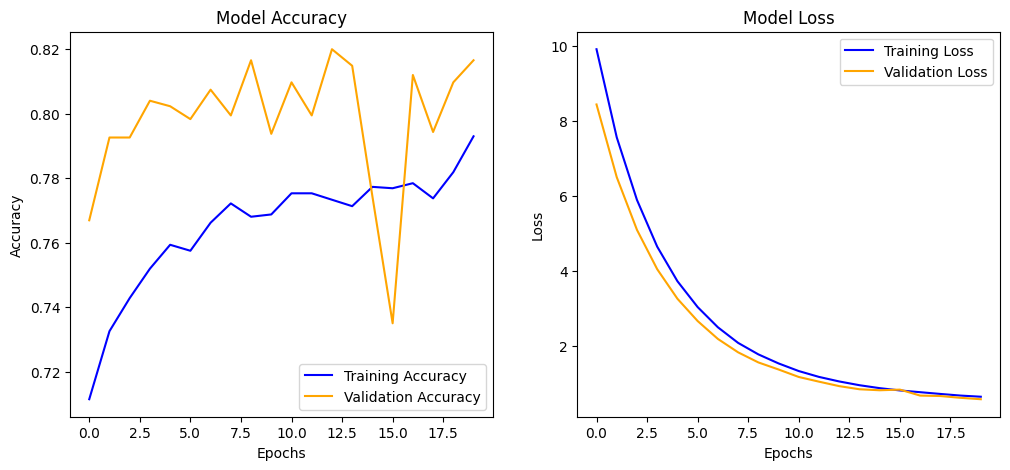

✅ Final Training Accuracy: 79.30%
✅ Final Validation Accuracy: 81.65%


In [14]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss graphs
def plot_training_history(history):
    """
    Plots accuracy and loss graphs for training & validation data.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy Plot
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    # Loss Plot
    axes[1].plot(history.history['loss'], label='Training Loss', color='blue')
    axes[1].plot(history.history['val_loss'], label='Validation Loss', color='orange')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.show()

# Call function after training to plot graphs
plot_training_history(history)

# Print final accuracy
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"✅ Final Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"✅ Final Validation Accuracy: {final_val_acc * 100:.2f}%")

55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step


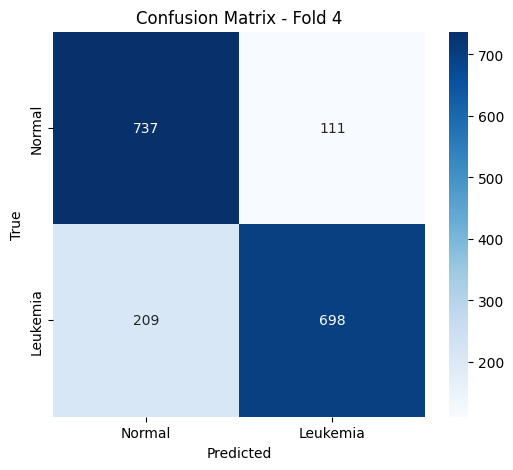

Classification Report for Fold 4:
              precision    recall  f1-score   support

      Normal       0.78      0.87      0.82       848
    Leukemia       0.86      0.77      0.81       907

    accuracy                           0.82      1755
   macro avg       0.82      0.82      0.82      1755
weighted avg       0.82      0.82      0.82      1755

🎉 Confusion Matrix and Classification Report for Fold 4 Displayed!


In [15]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the saved model for Fold 4
model = tf.keras.models.load_model("EfficientNetB3_Leukemia_Fold2.keras")

# Get the validation data for Fold 4 (same data as used in the training loop)
X_train_fold, X_val_fold = X_train[val_index], X_train[val_index]
y_train_fold, y_val_fold = y_train[val_index], y_train[val_index]

# Convert labels to categorical for Fold 4
y_val_fold = tf.keras.utils.to_categorical(y_val_fold, num_classes=2)

# Get predictions on the validation set for Fold 4
y_pred_fold = model.predict(X_val_fold)

# Convert predictions to class labels (0 or 1)
y_pred_class = np.argmax(y_pred_fold, axis=1)
y_true_class = np.argmax(y_val_fold, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true_class, y_pred_class)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Leukemia'], yticklabels=['Normal', 'Leukemia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Fold 4')
plt.show()

# Generate and display the classification report
report = classification_report(y_true_class, y_pred_class, target_names=['Normal', 'Leukemia'])
print("Classification Report for Fold 4:")
print(report)

print("🎉 Confusion Matrix and Classification Report for Fold 4 Displayed!")


In [ ]:
import pydot
import graphviz
print("done")

done


In [ ]:
#model diagram
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

# Load the best model (Fold 4)
model = load_model("EfficientNetB3_Leukemia_Fold4.keras")

# Generate a visualization
plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True)

print("Model architecture saved as model_architecture.png")

Model architecture saved as model_architecture.png


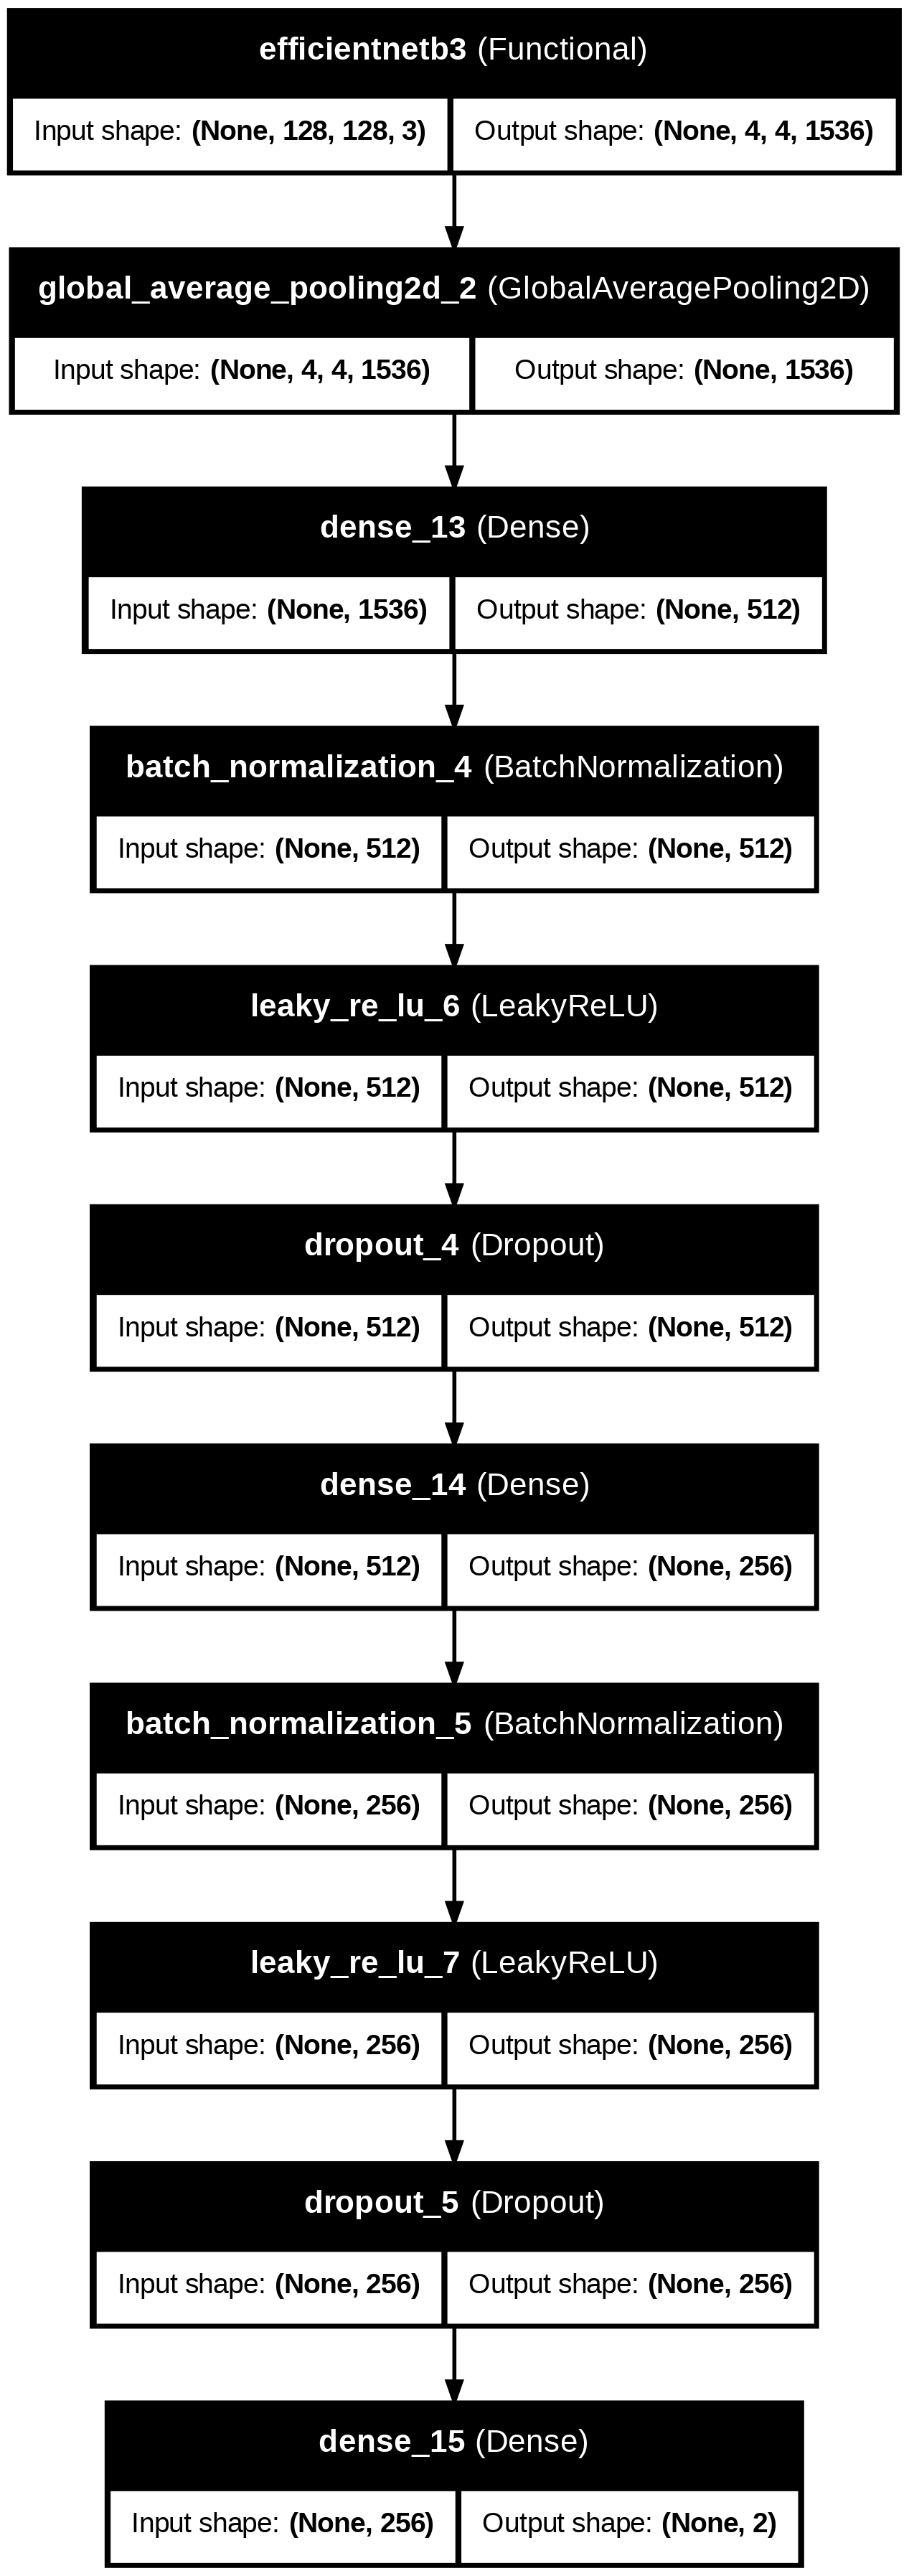

In [ ]:
from IPython.display import Image, display

# Display the saved model architecture image
display(Image(filename='model_architecture.png'))
